# 5.4.5 Land CSEM for detecting a buried conductive layer

Numerical examples of the book  

### Introduction to Controlled-Source Electromagnetic Methods  
Anton Ziolkowski and Evert Slob, 2019, *Cambridge University Press*; ISBN: [9781107058620](https://www.cambridge.org/9781107058620).

- - -
Copyright 2018 Dieter Werthmüller

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at [http://www.apache.org/licenses/LICENSE-2.0](http://www.apache.org/licenses/LICENSE-2.0). Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

In [1]:
import numpy as np
import empymod as epm
import matplotlib.pyplot as plt

%matplotlib inline

### Choose your preferred colour map

The book shows in the chapter black-and-white figures, and in the plate section coloured versions.

In [2]:
plt.rcParams['image.cmap'] = 'viridis'  # Colour
# plt.rcParams['image.cmap'] = 'gray'   # Black-and-white

## Calculation

### General model parameters

In [3]:
# Offsets for period-amplitude plots
x = 5e2+np.linspace(0, 1.95e4, 196)

# Periods for offset-amplitude plots
t = np.logspace(-2.5, 0.5, 101)

# Common model parameters
model = {'src': [0, 0, 1e-50],             # Source location
         'rec': [x, x*0, 1e-50],           # Receiver location
         'freqtime': t,                    # Times
         'signal': 0,                      # Impulse response
         'res': [2e14, 30, 1, 30],         # Resistivity
         'epermH': [0, 1, 1, 1],           # To avoid numerical issues due to air layer
         'epermV': [0, 1, 1, 1],           # " " "
         'htarg': 'key_201_2012',          # Use same filter as in book
         # 'htarg': ['key_201_2012', -1],  # Use lagged conv. Much faster.
         'ft': 'sin',                      # Sine-Fourier
         'ftarg': 'key_SinCos_201_2012',   # Use same filter as in book
         'verb': 1}                        # Verbosity

# Target at 2 km depth
ex2km = epm.dipole(depth=[0, 2000, 2040], **model)

# Analytical, diffusive half-space solution
hs = epm.analytical(src=[0, 0, 1e-50], rec=[x, x*0, 1e-50], signal=0,
                    res=30, freqtime=t, solution='dhs', verb=1)

### Create noise and add to the data

In [4]:
# Generate noise
mask = 1e-2*(1.5 - np.random.random_sample(hs.shape))
mask0 = 1e-2*(1.5 - np.random.random_sample(hs.shape))
maskn = 1e-15*(1.5 - np.random.random_sample(hs.shape))
maskn0 = 1e-15*(1.5 - np.random.random_sample(hs.shape))

# Apply noise
ex2kmn = ex2km*(1 + mask) + np.sign(ex2km)*maskn
hsn = hs*(1 + mask0) + maskn0

### Plotting functions

In [5]:
def plot_result(data, error=False):
    """Create figure.
    
    Most figures in this section are very similar, and just differ in
    the shown data. We can therefore define a plot-function which
    we subsequently call with the different results.
    
    """
    n = len(data)

    # Define figure size depending if 2 or 4 data-sets.
    if n == 2:
        tit = ['Half-space response', 'Depth to conductor: 2 km']
        size = (12, 6)
        clbargs = {'location': 'bottom', 'fraction': .05,
                   'pad': 0.2, 'aspect': 30}
    else:
        tit = ['Depth to conductor: 2 km']
        size = (6, 6)
        clbargs = {'location': 'bottom'}
        
    if error:
        clbticks = [-2, -1, 0, 1, 2]
        vmin = -2
        vmax = 2
    else:
        clbticks = [-16, -14, -12, -10, -8]
        vmin = -16
        vmax = -8

    # Start figure
    fig, axs = plt.subplots(figsize=size, nrows=1, ncols=n)
    if n == 2:
        axs = axs.ravel()
        plt.subplots_adjust(hspace=0.3, wspace=0.3)
    else:
        axs = [axs,]
    
    # Loop over data
    for i, val in enumerate(data):
        plt.sca(axs[i])
        plt.title(tit[i % 2], fontweight='bold')

        # pcolormesh takes x/y as start and end point of pixels,
        # not midpoints. So we have to create these.
        dx = (x[1]-x[0])/2
        px = np.r_[x-dx, x[-1]+dx]/1000
        lt = np.log10(t)
        dt = (lt[1]-lt[0])/2
        pt = 10**(np.r_[lt-dt, lt[-1]+dt])
        
        # Plot result
        cs = plt.pcolormesh(px, pt, np.log10(np.abs(val)), vmin=vmin, vmax=vmax)
        
        # Plot contours
        level_factor = 2
        if (vmax-vmin) < 4:
            level_factor *= 2
        levels = np.linspace(vmin, vmax, level_factor*(vmax-vmin)+1)
        cs2 = plt.contour(x/1000, t, np.log10(np.abs(val)),
                          levels=levels,
                          linewidths=0.5, colors=[(0, 0, 0, 0.5)])
            
        plt.xticks([5, 10, 15, 20])
        plt.xlabel('Offset (km)')
        plt.ylabel('$\log_{10}(t)$ (s)')
        axs[i].set_yscale('log')
        axs[i].invert_yaxis()
        plt.yticks([1e0, 1e-1, 1e-2], ('0', '-1', '-2'))

    # Plot colorbar
    cax, kw = plt.matplotlib.colorbar.make_axes(axs, **clbargs)
    cb = plt.colorbar(cs, cax=cax, ticks=clbticks, **kw)

    plt.show()


def set_axis(t=False):
    """General settings for line plots."""
    if np.any(t):
        plt.xlabel('Time (s)')
        plt.xlim([1e-1, 1e2])
    else:
        plt.xlabel('Offset (km)')
        plt.xlim([0, 15])
        plt.xticks([0, 5, 10, 15])
    plt.ylabel('Electric field (V/m)')
    plt.ylim([1e-15, plt.gca().get_ylim()[1]])
    plt.legend()

## Figure 5.59

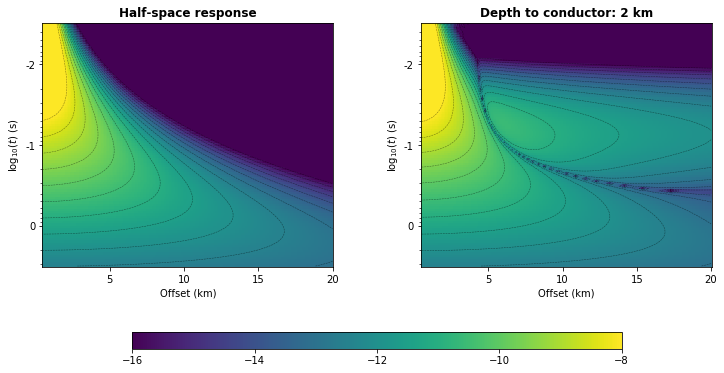

In [6]:
plot_result([hs, ex2km])

Figure 5.59 Electric field impulse response as a function of logarithmic time and offset for the isotropic 30 $\Omega\,$m half-space model (left) and the half-space with 40 m thick 1 $\Omega\,$m layer in the half-space (right).

## Figure 5.60

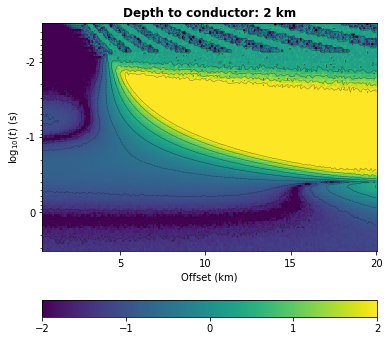

In [7]:
plot_result([(ex2kmn-hsn)/hsn], True)

Figure 5.60 Electric field impulse response difference between the models with and without conductive layer as shown in Figure 5.59, but using the noise model, as a function of logarithmic time offset. The colour bar indicates the normalised difference in logarithmic scale.

## Figure 5.61

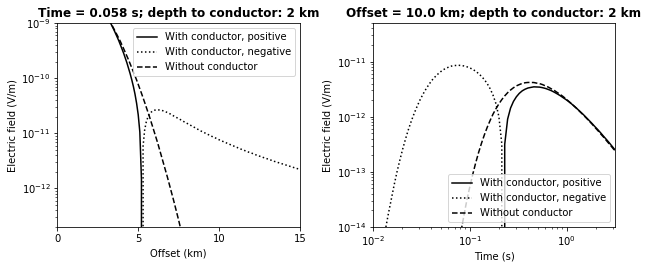

In [8]:
# Define indices
nx2 = 95
nt2 = 42

plt.figure(figsize=(10, 9))
plt.subplots_adjust(wspace=.3, hspace=.4)

# 1st subplot
plt.subplot(221)
plt.title('Time = '+str(np.round(t[nt2], 3))+' s; depth to conductor: 2 km'
          , fontweight='bold')
plt.semilogy(x/1000, ex2kmn[nt2, :], 'k-', label='With conductor, positive')
plt.semilogy(x/1000, -ex2kmn[nt2, :], 'k:', label='With conductor, negative')
plt.semilogy(x/1000, hsn[nt2, :], 'k--', label='Without conductor')
plt.xlabel('Offset (km)')
plt.ylabel('Electric field (V/m)')
plt.xlim([0, 15])
plt.xticks([0, 5, 10, 15])
plt.ylim([2e-13, 1e-9])
plt.legend()

# 3rd subplot
plt.subplot(222)
plt.title('Offset = '+str(np.round(x[nx2])/1000) +
          ' km; depth to conductor: 2 km', fontweight='bold')
plt.loglog(t, ex2kmn[:, nx2], 'k-', label='With conductor, positive')
plt.loglog(t, -ex2kmn[:, nx2], 'k:', label='With conductor, negative')
plt.loglog(t, hsn[:, nx2], 'k--', label='Without conductor')
plt.xlabel('Time (s)')
plt.ylabel('Electric field (V/m)')
plt.xlim([1e-2, 3.16228])
plt.ylim([1e-14, 5e-11])
plt.legend()

plt.show()

Figure 5.61 Electric field impulse response for the isotropic land model with (solid line: positive values and dotted line: negative values) and without (dashed lines) the conductive layer buried at 2 km depth as a function of offset at the time of the maximum difference (left) and as a function of time at the offset of the maximum difference (right).

In [9]:
epm.versions('HTML')